In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import resample
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from sklearn.metrics import accuracy_score, classification_report
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


In [2]:
import pandas as pd

def get_df(path = 'reviews_with_sentiments.csv'):
    return pd.read_csv(path)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

def get_info(df):
    print(f'Общая информация о наборе данных\n{df.info()}\n')
    print(f'\nПроверка пропусков в данных\n{df.isnull().sum()}\n')

    print(f'\nПроверка на выбросы в оценке\n{df['Sentiment'].describe()}')
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df['Sentiment'])
    plt.title('Выбросы в оценке')
    plt.show()

    print('Балансировка по классу оценки')
    plt.figure(figsize=(10, 5))
    sns.histplot(df['Sentiment'], bins=20, kde=True, color='blue')
    plt.title('Распределение оценок Sentiment')
    plt.xlabel('Sentiment')
    plt.ylabel('Частота')
    plt.show()

    print('Анализ длины отзывов')
    df['Review_Length'] = df['Review'].astype(str).apply(len)
    plt.figure(figsize=(10, 5))
    sns.histplot(df['Review_Length'], bins=50, kde=True, color='green')
    plt.title('Распределение длины отзывов')
    plt.xlabel('Длина отзыва')
    plt.ylabel('Частота')
    plt.show()
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18036 entries, 0 to 18035
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Film       18036 non-null  object
 1   Review     18036 non-null  object
 2   Sentiment  18036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 422.8+ KB
Общая информация о наборе данных
None


Проверка пропусков в данных
Film         0
Review       0
Sentiment    0
dtype: int64


Проверка на выбросы в оценке
count    18036.000000
mean         0.733755
std          0.598468
min         -1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: Sentiment, dtype: float64


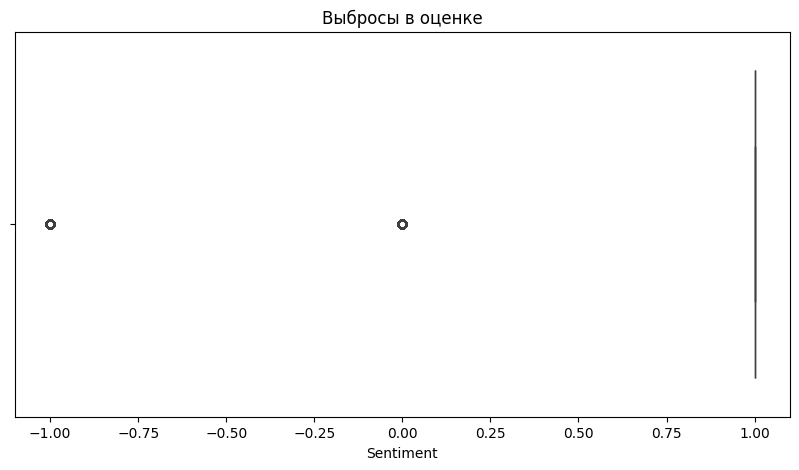

Балансировка по классу оценки


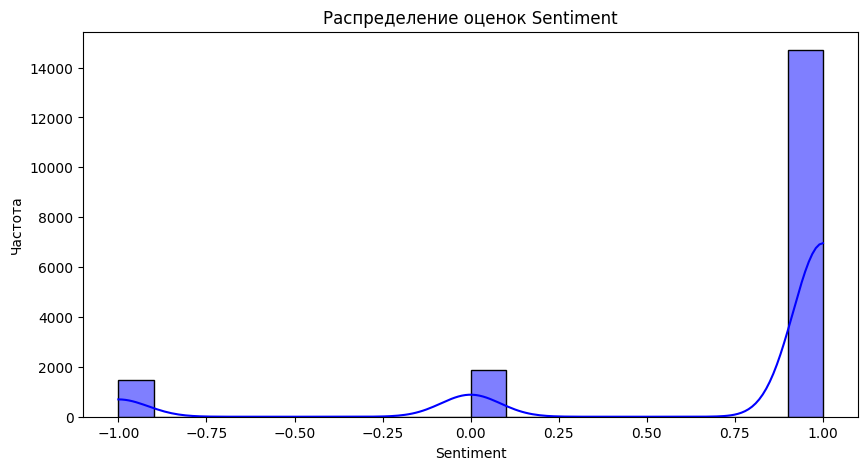

Анализ длины отзывов


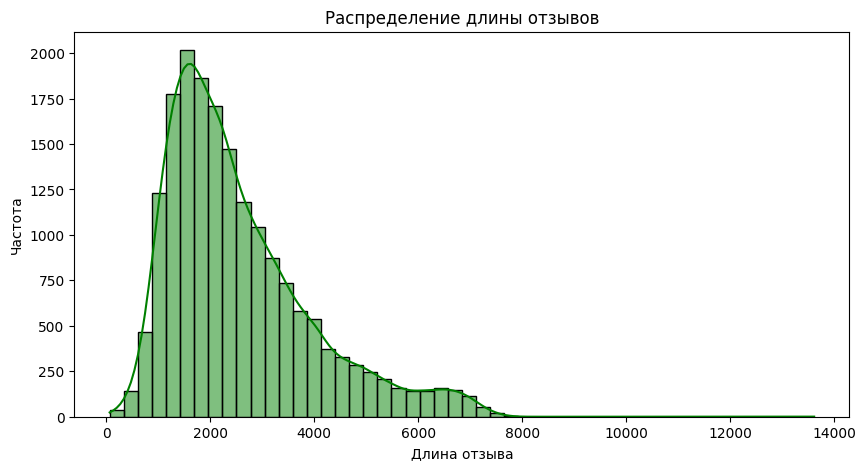

In [4]:
df = get_df()
get_info(df)

Из графика видно, что классы сильно не сбалансированы => проведем балансировку классов

<class 'pandas.core.frame.DataFrame'>
Index: 4802 entries, 11726 to 18025
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Film       4802 non-null   object
 1   Review     4802 non-null   object
 2   Sentiment  4802 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 150.1+ KB
Общая информация о наборе данных
None


Проверка пропусков в данных
Film         0
Review       0
Sentiment    0
dtype: int64


Проверка на выбросы в оценке
count    4802.00000
mean        0.00000
std         0.78201
min        -1.00000
25%        -1.00000
50%         0.00000
75%         1.00000
max         1.00000
Name: Sentiment, dtype: float64


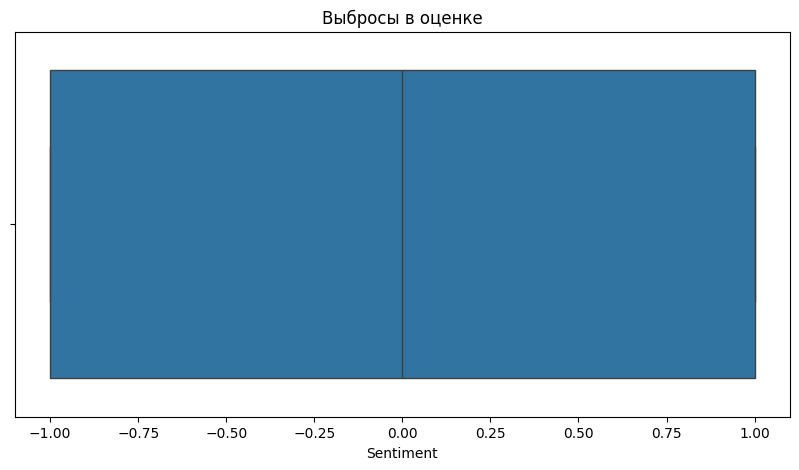

Балансировка по классу оценки


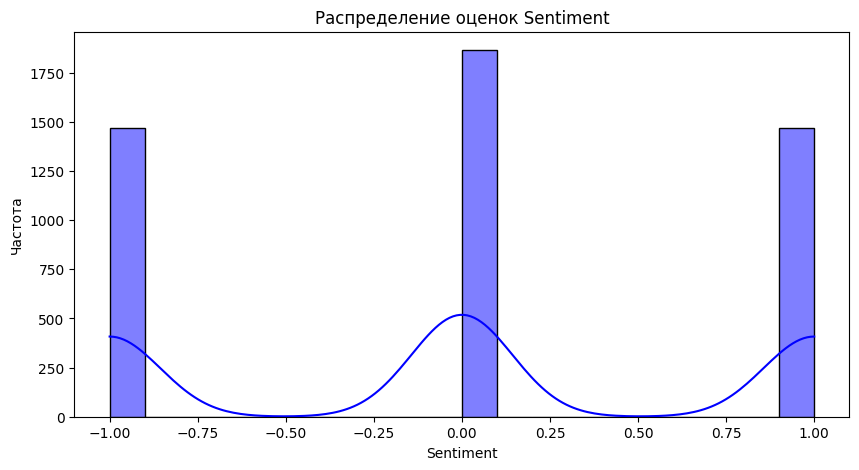

Анализ длины отзывов


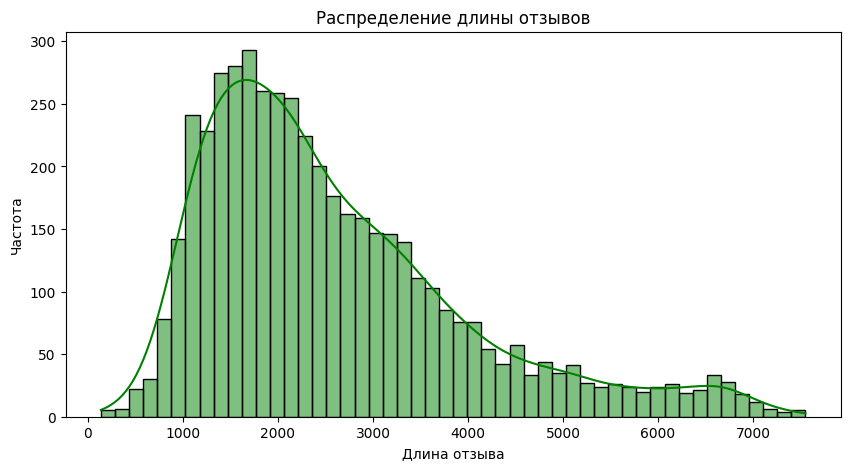

In [5]:
df = pd.read_csv('reviews_with_sentiments.csv')
df_majority = df[df['Sentiment'] == 1]
df_minority = df[df['Sentiment'] == -1] 
df_neutral = df[df['Sentiment'] == 0]  

df_majority_downsampled = resample(df_majority, replace=False, n_samples=len(df_minority), random_state=42)
df_balanced = pd.concat([df_majority_downsampled, df_minority, df_neutral])
get_info(df_balanced)

In [6]:

nltk.download('punkt', quiet=True)

nltk.download('stopwords')
stop_words = stopwords.words('russian')
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower() 
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

df_balanced['Review'] = df_balanced['Review'].apply(preprocess_text)


X = df_balanced['Review']
y = df_balanced['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(sublinear_tf=True, norm='l2', stop_words=stop_words)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

models = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(),
}

for model_name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    
    print(f"Evaluation for {model_name}:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Юлия\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Evaluation for Logistic Regression:
Accuracy: 0.6451612903225806
              precision    recall  f1-score   support

          -1       0.72      0.58      0.64       284
           0       0.53      0.67      0.59       359
           1       0.76      0.68      0.72       318

    accuracy                           0.65       961
   macro avg       0.67      0.64      0.65       961
weighted avg       0.66      0.65      0.65       961

Evaluation for SVM:
Accuracy: 0.595213319458897
              precision    recall  f1-score   support

          -1       0.88      0.32      0.47       284
           0       0.48      0.89      0.62       359
           1       0.84      0.51      0.63       318

    accuracy                           0.60       961
   macro avg       0.73      0.57      0.58       961
weighted avg       0.72      0.60      0.58       961



Мы видим, что точность низкая. Это связано с тем, что нейтральные отзывы не имеют эмоциональных фраз, а значит слова, используемые для нейтральной оценки могут равновероятно встречаться в любом типе отзывов, что сильно снижает качество классификации. Попробуем удалить нейтральные отзывы для увеличения точности определения тональности отзывов.

In [7]:
df_balanced_without_neutral = df_balanced[df_balanced['Sentiment'] != 0]

X = df_balanced_without_neutral['Review']
y = df_balanced_without_neutral['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(sublinear_tf=True, norm='l2', stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


models = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(),
}

for model_name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    
    print(f"Evaluation for {model_name}:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))


Evaluation for Logistic Regression:
Accuracy: 0.9030612244897959
              precision    recall  f1-score   support

          -1       0.88      0.93      0.90       292
           1       0.93      0.88      0.90       296

    accuracy                           0.90       588
   macro avg       0.90      0.90      0.90       588
weighted avg       0.90      0.90      0.90       588

Evaluation for SVM:
Accuracy: 0.9030612244897959
              precision    recall  f1-score   support

          -1       0.88      0.93      0.91       292
           1       0.93      0.88      0.90       296

    accuracy                           0.90       588
   macro avg       0.90      0.90      0.90       588
weighted avg       0.90      0.90      0.90       588



In [8]:
X = df_balanced['Review']
y = df_balanced['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)


tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_seq_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_seq_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_seq_length)


model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=150, input_length=max_seq_length)) 
model.add(Bidirectional(LSTM(units=64, return_sequences=True))) 
model.add(Dropout(0.3)) 
model.add(LSTM(units=64)) 
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


model.fit(X_train_pad, y_train, epochs=5, validation_data=(X_test_pad, y_test))
y_pred = (model.predict(X_test_pad) > 0.5).astype('int32')

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))


C:\Users\Юлия\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.3878 - loss: 0.2513 - val_accuracy: 0.4069 - val_loss: -1.3258
Epoch 2/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step - accuracy: 0.5006 - loss: -9.2131 - val_accuracy: 0.3996 - val_loss: -45.2821
Epoch 3/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - accuracy: 0.5462 - loss: -116.7641 - val_accuracy: 0.4194 - val_loss: -204.1157
Epoch 4/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step - accuracy: 0.5269 - loss: -343.6937 - val_accuracy: 0.4194 - val_loss: -385.9843
Epoch 5/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - accuracy: 0.5275 - loss: -682.0212 - val_accuracy: 0.3861 - val_loss: -598.3820
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Accuracy: 0.38605619146722164
              precision    recall  f1-score   support

           0       0.48      0.46      0.47       284
           1       0.35      0.67      0.46       359
           2       0.00      0.00      0.00       318

    accuracy                           0

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [9]:
df_balanced = df_balanced_without_neutral

X = df_balanced['Review']
y = df_balanced['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_seq_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_seq_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_seq_length)


model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=150, input_length=max_seq_length))
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(Dropout(0.3))
model.add(LSTM(units=64))
model.add(Dense(units=128, activation='relu')) 
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_pad, y_train, epochs=5, validation_data=(X_test_pad, y_test))
y_pred = (model.predict(X_test_pad) > 0.5).astype('int32')

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))


Epoch 1/5


C:\Users\Юлия\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - accuracy: 0.5622 - loss: 0.6661 - val_accuracy: 0.7925 - val_loss: 0.4433
Epoch 2/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 0.9279 - loss: 0.1933 - val_accuracy: 0.8112 - val_loss: 0.4719
Epoch 3/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.9965 - loss: 0.0266 - val_accuracy: 0.8044 - val_loss: 0.6359
Epoch 4/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 0.9980 - loss: 0.0060 - val_accuracy: 0.8061 - val_loss: 1.0815
Epoch 5/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - accuracy: 1.0000 - loss: 2.3655e-04 - val_accuracy: 0.8044 - val_loss: 1.1324
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
Accuracy: 0.8044217687074829
              precision    recall  f1-score   support

           0       0.82      0.77      0.80       292
           1       0.79      0.84      0.81       296

    accuracy                           0.80       588
   macro avg       0.81      0.80      0.80       588
weighted avg       0.81      